In [87]:
from __future__ import print_function
from __future__ import division
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import GPy
from pandas import Series, DataFrame
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from IPython.core.pylabtools import figsize

%matplotlib inline
figsize(17, 7)

# Load and adjust the data

In [88]:
df_train = pd.read_csv('../../data/TableS2_training.csv', keep_default_na=False)
columns = ['Name', 'Short Name', 'MV', 'abs_mob', 'logD', 'RRF_Measured', 'RRF_Predicted']
features = ['MV', 'abs_mob', 'logD']

df_train = df_train[df_train['Annotation'] == '']
df_train['RRF_Measured'] = df_train['RRF_Measured'] * 1e-2
df_train['RRF_Predicted'] = df_train['RRF_Predicted'] * 1e-2

df_test = pd.read_csv('../../data/TableS3_training.csv', keep_default_na=False)

df_test['RRF_Measured'] = df_test['RRF_Measured'] * 1e-2
df_test['RRF_Predicted'] = df_test['RRF_Predicted'] * 1e-2

df = pd.concat([df_train, df_test])
df = df[columns]
df.reset_index(inplace=True, drop=True)
df.head(3)

,Name,Short Name,MV,abs_mob,logD,RRF_Measured,RRF_Predicted
0,Histamine,HisN,98.5,0.000736,-2.31,0.00111,0.00615
1,L-Valine,Val,107.0,0.000232,-2.30,0.00188,0.00263
2,Nicotinamide,NAm,94.6,0.000439,0.40,0.00322,0.00755


In [89]:
NUM_RUNS = 1000
TEST_SIZE = 0.2 # 0.2

regr = linear_model.LinearRegression()

results = []

for i in range(NUM_RUNS):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        df[features], df['RRF_Measured'], test_size=TEST_SIZE, random_state=i)
    
    # Fit Linear Regression
    regr.fit(X_train, y_train)

    # Fit Gaussien Process
    gp = GPy.models.GPRegression(X_train.values, y_train[:].reshape(-1, 1))
    gp.optimize()
    
    # Predict
    y_pred = regr.predict(X_test)
    mu, var = gp.predict(X_test.values)
    
    result = {
        'LR_R2_SCORE': r2_score(y_test, y_pred),
        'LR_MEAN_ABS_ERROR': mean_absolute_error(y_test, y_pred),
        'GP_R2_SCORE': r2_score(y_test, mu),
    }
    
    results.append(result)

df_results = DataFrame(results)

print("Trained on {} and Tested on {} data points".format(len(X_train), len(X_test)))

df_results.describe()

Trained on 36 and Tested on 10 data points


,GP_R2_SCORE,LR_MEAN_ABS_ERROR,LR_R2_SCORE
count,1000.000000,1000.000000,1000.000000
mean,0.456005,0.006116,0.740685
std,0.588313,0.001493,0.210710
min,-5.795466,0.002388,-0.724063
25%,0.308690,0.004993,0.703592
50%,0.653424,0.006032,0.814995
75%,0.813918,0.007115,0.862088
max,0.974208,0.010539,0.966604


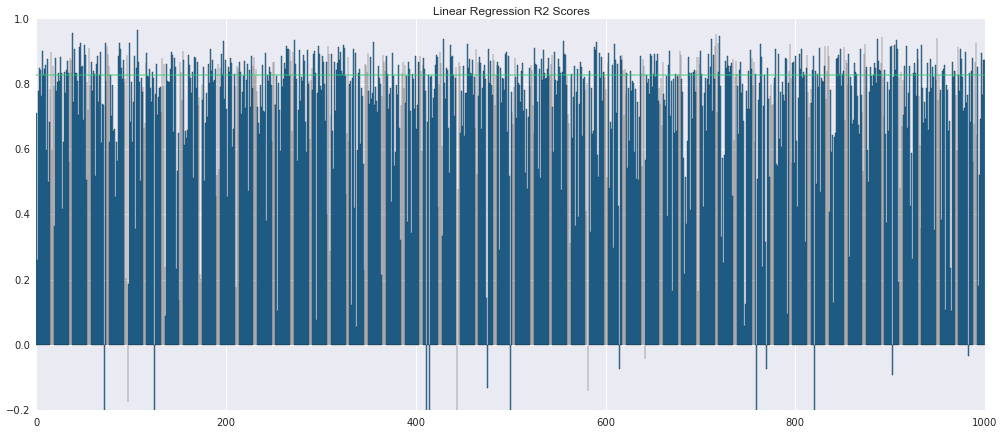

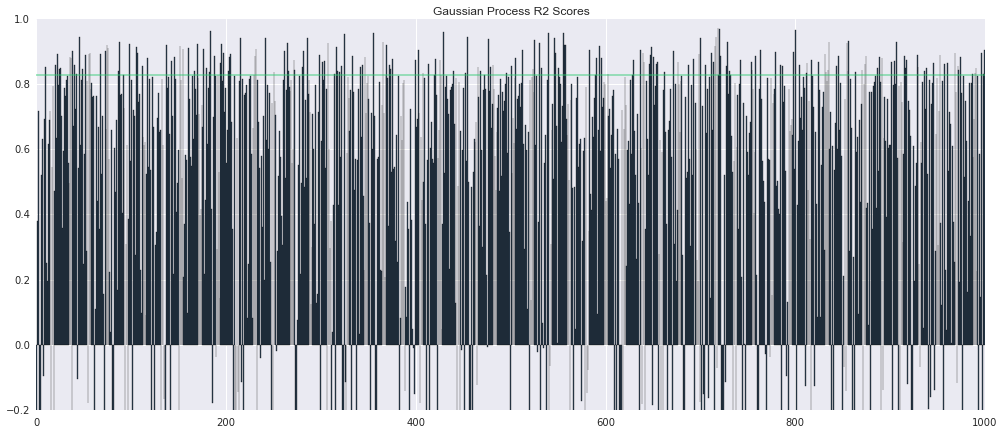

In [90]:
plt.bar(df_results.index, df_results['LR_R2_SCORE'], color='#3498db')
plt.axhline(y=0.828341767487, color='#2ecc71', alpha=0.5)
plt.grid(True)
plt.title('Linear Regression R2 Scores')
plt.ylim([-0.2, 1.0])
plt.show()

plt.bar(df_results.index, df_results['GP_R2_SCORE'], color='#34495e')
plt.axhline(y=0.828341767487, color='#2ecc71', alpha=0.5)
plt.grid(True)
plt.title('Gaussian Process R2 Scores')
plt.ylim([-0.2, 1.0])
plt.show()